**Lesson 10 – Deep Learning**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Deep neural networks have more than one hidden layes. As we add more layers, we may face several problems:
    1. Vanishing gradients problem (or the related exploding gradients problem) that affects deep neural networks and makes lower layers very hard to train.
    2. Slow Training
    3. Risk overfitting the training set
  We will look at these problem and try to solve them.

# Vanishing/Exploding Gradients Problem

Backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient on the way. Once the algorithm has computed the gradient of the cost function with regards to each parameter in the network, it uses these gradients to update each parameter with a Gradient Descent step. <br>

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layer connection weights virtually unchanged, and training never converges to a good solution. This is called the vanishing gradients problem. <br>

In some cases, the opposite can happen: the gradients can grow bigger and bigger, so many layers get insanely large weight updates and the algorithm diverges. This is the exploding gradients problem, which is mostly encountered in recurrent neural networks. More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds. <br>

This problem was largely unresolved until 2010 A paper titled “Understanding the Difficulty of Training
Deep Feedforward Neural Networks” by Xavier Glorot and Yoshua Bengi found that random weight initialization using a normal distribution with a mean of 0 and a standard deviation of 1 fixes the problem. If this is not done, the variance is increases with each additional layer. <br>

This is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the logistic function in deep networks). <br>

In Logistic activation function inputs may become large (negative or positive) and the function saturates at 0 or 1, with a derivative extremely close to 0. When backpropagation starts, it has little gradient to propagate back through the network, and this small gradient keeps getting diluted as backpropagation progresses down through the top layers, so there is really nothing left for the lower layers. <br>

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


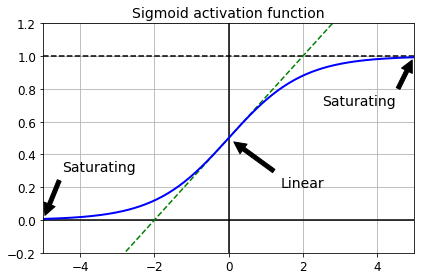

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

The signal need to signal to flow properly in both directions: in the forward direction when making predictions, and in the
reverse direction when backpropagating gradients without dying or saturation. <br>

The proposed solution by Glorot and Bengio requires equal variance in inputs and outputs. It is actually not possible unless the layer has an equal number of input and output connections. But there is a good compromise: <br>

The connection weights must be initialized randomly according to the following formula (Xavier or Glorot initialization) of logistic activation function. <br>

Normal distribution with mean 0 and standard deviation $\sigma=\sqrt{\frac{2}{n_{inputs} + n_{outputs}}}$ <br>

For uniform distribution $U(-r,r)$ with $r=\sqrt{\frac{6}{n_{inputs} + n_{outputs}}}$ <br>

When the number of of connections is equal it can be simplified to $\sigma = \sqrt{\frac{1}{n_{inputs}}}$

For ReLU



In [4]:
import tensorflow as tf

In [5]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

We use *he_init* for He initialization.

In [6]:
# Load He initializer
he_init = tf.variance_scaling_initializer()
# Use it to specify a hidden neural level.
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

## Nonsaturating Activation Functions

Glorot and Bengio show that the vanishing/exploding gradients problems were in part due to a poor choice of activation function. Sigmoid function copied from biology is not a good choice. ReLU activation function performs much better, mostly it does not produce extreme values and is fast to compute. <br>


ReLU wiht large learning rate suffers from a problem known as the dying neurons when they stop outputting anything other than 0. If the updated weights produce $z<0$ the ReLU function will return 0 and the gradiend will be also 0. This neuron is likely to stay dead. <br>

There a few ways to solve this problem: <br>

1. Leaky ReLU defined as $LeakyReLU \alpha(z) = \max(\alpha z, z)$. The hyperparameter $\alpha$ defines how much the function “leaks”: it is the slope of the function for z < 0, and is typically set to 0.01.  This small slope ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up. Leaky ReLU tends to outperfrom ReLU activation function. Large $\alpha=0.2$ sometimes performs better than 0.01. 

2. Randomized Leaky ReLU (RReLU), where $\alpha$ is picked randomly during training and fixed during testing. This randomization reduces overfitting.

3. Parametric Leaky ReLU (PReLU) where we optimeze parameter $\alpha$ during backpropagation. This methods overperforms other ReLU on large datasets, but tends to overfit smaller ones. 

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


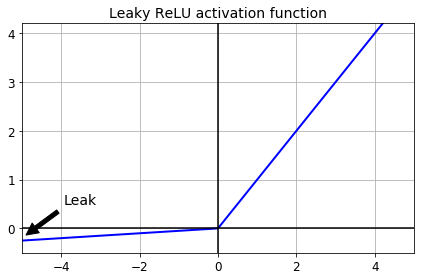

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

Implementing Leaky ReLU in TensorFlow:

In [9]:
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

There is not prepackaged LReLU function, but we can define it and program a network layer with it:

In [10]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

In [11]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [12]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

Specify two hidden layers with 300, and 100 neurons.

In [13]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

Specify loss function for error calculation.

In [14]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

Set learning rate at 0.01. Use GradientDescent to minimize loss function. 

In [15]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

Set-up predictions of accuracy.

In [16]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's load the data:

**Warning**: `tf.examples.tutorials.mnist` is deprecated. We will use `tf.keras.datasets.mnist` instead. <br>
Load first 5000 obs into validation and other into training.


In [18]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

Setup batch processing of data.

In [19]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

Run our algorithm

In [20]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9044
5 Batch accuracy: 0.94 Validation accuracy: 0.9494
10 Batch accuracy: 0.92 Validation accuracy: 0.9656
15 Batch accuracy: 0.94 Validation accuracy: 0.971
20 Batch accuracy: 1.0 Validation accuracy: 0.9762
25 Batch accuracy: 1.0 Validation accuracy: 0.9772
30 Batch accuracy: 0.98 Validation accuracy: 0.9782
35 Batch accuracy: 1.0 Validation accuracy: 0.9788


### ELU

Djork-Arné Clevert et al. the exponential linear unit (ELU) activation function, it tends to outperform other ReLU both in time and testing accuracy:
$$ELU_{\alpha}(z) = \begin{cases} \alpha(\exp(z) -1) \quad &if \quad z<0 \\ z \quad &if \quad z \geq 0 \end{cases}$$

It looks a lot like the ReLU function, with a few major differences:
1. It take negative values when z < 0, which allows the unit to have an average output closer to 0 helping to alleviate vanishing gradients problem.
2. The hyperparameter $\alpha$ defines the value that the ELU function approaches when z is a large negative number. It is usually set to 1, but you can be tweaked.
3. ELU has a nonzero gradient for $z < 0$, which avoids the dying units issue.
4. ELU is is smooth everywhere, including around z = 0, which helps speed up Gradient Descent. <br>


The main drawback of the ELU activation function is that it is slower to compute than the ReLU and its
variants (due to the use of the exponential function), but during training this is compensated by the faster
convergence rate. However, at test time an ELU network will be slower than a ReLU network.

In [21]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


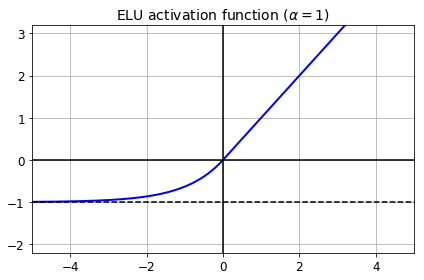

In [22]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [23]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

Tensorflow has a pre-defined ELU function:

In [24]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, 2017. During training, a neural network composed of a stack of dense layers using the SELU activation function will self-normalize: <br>

The output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out.
$$selu(x)=\lambda \begin{cases} \alpha\exp(z) - \alpha \quad &if \quad z<0 \\ x \quad &if \quad z \geq 0 \end{cases}$$
We solve for $\alpha$ and $\lambda$ to find a fixed point that preserves mean and variance from layer to layer:
$$g(\mu, v, \alpha, \lambda) = (\mu, v)$$
Gradients neigher explode nor vanish. 




In [25]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

Saving figure selu_plot


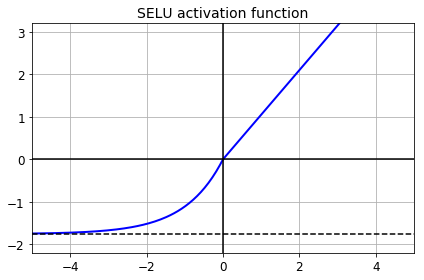

In [26]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 100 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [27]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))
for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 10: -0.24 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 20: -0.17 < mean < 0.18, 0.74 < std deviation < 1.24
Layer 30: -0.27 < mean < 0.24, 0.78 < std deviation < 1.20
Layer 40: -0.38 < mean < 0.39, 0.74 < std deviation < 1.25
Layer 50: -0.27 < mean < 0.31, 0.73 < std deviation < 1.27
Layer 60: -0.26 < mean < 0.43, 0.74 < std deviation < 1.35
Layer 70: -0.19 < mean < 0.21, 0.75 < std deviation < 1.21
Layer 80: -0.18 < mean < 0.16, 0.72 < std deviation < 1.19
Layer 90: -0.19 < mean < 0.16, 0.75 < std deviation < 1.20


The `tf.nn.selu()` function was added in TensorFlow 1.4. For earlier versions, you can use the following implementation:

In [28]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

However, the SELU activation function cannot be used along with regular Dropout (this would cancel the SELU activation function's self-normalizing property). Fortunately, there is a Dropout variant called Alpha Dropout proposed in the same paper. It is available in `tf.contrib.nn.alpha_dropout()` since TF 1.4 (or check out [this implementation](https://github.com/bioinf-jku/SNNs/blob/master/selu.py) by the Institute of Bioinformatics, Johannes Kepler University Linz).

Let's create a neural net for MNIST using the SELU activation function:

In [29]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
# Set-up two hiddne layers
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [30]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.88 Validation accuracy: 0.9232
5 Batch accuracy: 0.98 Validation accuracy: 0.9574
10 Batch accuracy: 1.0 Validation accuracy: 0.9662
15 Batch accuracy: 0.96 Validation accuracy: 0.9684
20 Batch accuracy: 1.0 Validation accuracy: 0.9692
25 Batch accuracy: 1.0 Validation accuracy: 0.969
30 Batch accuracy: 1.0 Validation accuracy: 0.9694
35 Batch accuracy: 1.0 Validation accuracy: 0.9702


The training data accuracy quickly approached 1, we probably overfitting. The main advantage of SELU is in deeper networks. It takes long time. 

In [31]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 2000
n_hidden2 = 500
n_hidden3 = 200
n_hidden4 = 60
n_hidden5 = 30
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
# Set-up two hiddne layers
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=selu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=selu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=selu, name="hidden5")

    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50


means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.98 Validation accuracy: 0.946
5 Batch accuracy: 1.0 Validation accuracy: 0.9682
10 Batch accuracy: 1.0 Validation accuracy: 0.9722
15 Batch accuracy: 0.98 Validation accuracy: 0.972
20 Batch accuracy: 1.0 Validation accuracy: 0.9724
25 Batch accuracy: 1.0 Validation accuracy: 0.972
30 Batch accuracy: 1.0 Validation accuracy: 0.9728
35 Batch accuracy: 1.0 Validation accuracy: 0.9734


# Batch Normalization

Note: the book uses `tensorflow.contrib.layers.batch_norm()` rather than `tf.layers.batch_normalization()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.batch_normalization()`, because anything in the contrib module may change or be deleted without notice. Instead of using the `batch_norm()` function as a regularizer parameter to the `fully_connected()` function, we now use `batch_normalization()` and we explicitly create a distinct layer. The parameters are a bit different, in particular:
* `decay` is renamed to `momentum`,
* `is_training` is renamed to `training`,
* `updates_collections` is removed: the update operations needed by batch normalization are added to the `UPDATE_OPS` collection and you need to explicity run these operations during training (see the execution phase below),
* we don't need to specify `scale=True`, as that is the default.

Also note that in order to run batch norm just _before_ each hidden layer's activation function, we apply the ELU activation function manually, right after the batch norm layer.

Note: since the `tf.layers.dense()` function is incompatible with `tf.contrib.layers.arg_scope()` (which is used in the book), we now use python's `functools.partial()` function instead. It makes it easy to create a `my_dense_layer()` function that just calls `tf.layers.dense()` with the desired parameters automatically set (unless they are overridden when calling `my_dense_layer()`). As you can see, the code remains very similar.

# I skip this material because it dupclicate SELU.

## Gradient Clipping

A popular technique to lessen the exploding gradients problem is to simply clip the gradients during
backpropagation so that they never exceed some threshold (this is mostly useful for recurrent neural
networks; see Chapter 14). <br>

In general people now prefer Batch Normalization/SELU, but it’s still useful to know about Gradient Clipping and how to implement it.In TensorFlow, the optimizer’s minimize() function takes care of both computing the gradients and
applying them, so we need: <br>
1. call the optimizer’s compute_gradients() method
2. clip the gradients using the clip_by_value() function
3. apply the clipped gradients using the optimizer’s apply_gradients() method

In [32]:
# Set up network
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [33]:
learning_rate = 0.01

Now we apply gradient clipping. For this, we need to get the gradients, use the `clip_by_value()` function to clip them, then apply them:

In [34]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
# Replace very large gradient values by threshold. 
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

The rest is the same as usual:

In [35]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [36]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [37]:
n_epochs = 20
batch_size = 200

In [38]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
# We save our checkpoint
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.2878
1 Validation accuracy: 0.7942
2 Validation accuracy: 0.8794
3 Validation accuracy: 0.9054
4 Validation accuracy: 0.9162
5 Validation accuracy: 0.9212
6 Validation accuracy: 0.9292
7 Validation accuracy: 0.9358
8 Validation accuracy: 0.9378
9 Validation accuracy: 0.9414
10 Validation accuracy: 0.9456
11 Validation accuracy: 0.9472
12 Validation accuracy: 0.9476
13 Validation accuracy: 0.9536
14 Validation accuracy: 0.9564
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9574
17 Validation accuracy: 0.9588
18 Validation accuracy: 0.9624
19 Validation accuracy: 0.9616


## Reusing Pretrained Layers

It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to
find an existing neural network that accomplishes a similar task to the one you are trying to tackle, then
just reuse the lower layers of this network: this is called transfer learning.  <br>
    
It will not only speed up training considerably, but will also require much less training data. <br>

For example, suppose that you have access to a DNN that was trained to classify pictures into 100
different categories, including animals, plants, vehicles, and everyday objects. You now want to train a
DNN to classify specific types of vehicles. These tasks are very similar, so you should try to reuse parts
of the first network. <br>

<p>
    <img src="images\Lesson10\image1.png" width="600" height="400" />
</p>

## Reusing a TensorFlow Model

First you need to load the graph's structure. The `import_meta_graph()` function does just that, loading the graph's operations into the default graph, and returning a `Saver` that you can then use to restore the model's state. Note that by default, a `Saver` saves the structure of the graph into a `.meta` file, so that's the file you should load:

In [39]:
reset_graph()

In [40]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

Next you need to get a handle on all the operations you will need for training. If you don't know the graph's structure, you can list all the operations:

In [41]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

Oops, that's a lot of operations! It's much easier to use TensorBoard to visualize the graph. The following hack will allow you to visualize the graph within Jupyter (if it does not work with your browser, you will need to use a `FileWriter` to save the graph and then visualize it in TensorBoard):

In [42]:
from tensorflow_graph_in_jupyter import show_graph

In [43]:
show_graph(tf.get_default_graph())

Once you know which operations you need, you can get a handle on them using the graph's `get_operation_by_name()` or `get_tensor_by_name()` methods:

In [44]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

If you are the author of the original model, you could make things easier for people who will reuse your model by giving operations very clear names and documenting them. Another approach is to create a collection containing all the important operations that people will want to get a handle on:

In [45]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important_ops", op)

This way people who reuse your model will be able to simply write:

In [46]:
X, y, accuracy, training_op = tf.get_collection("my_important_ops")

Now you can start a session, restore the model's state and continue training on your data:

In [47]:
# restore the checkpoint
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    # continue training the model...

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


Actually, let's test this for real!

In [48]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt") 
# The improvement is small, most of the model remain the same.

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9632
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9656
3 Validation accuracy: 0.965
4 Validation accuracy: 0.9642
5 Validation accuracy: 0.965
6 Validation accuracy: 0.9686
7 Validation accuracy: 0.9686
8 Validation accuracy: 0.9684
9 Validation accuracy: 0.9684
10 Validation accuracy: 0.9706
11 Validation accuracy: 0.9716
12 Validation accuracy: 0.967
13 Validation accuracy: 0.9706
14 Validation accuracy: 0.9712
15 Validation accuracy: 0.9724
16 Validation accuracy: 0.972
17 Validation accuracy: 0.9714
18 Validation accuracy: 0.9714
19 Validation accuracy: 0.9714


Alternatively, if you have access to the Python code that built the original graph, you can use it instead of `import_meta_graph()`:

In [49]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
# Save the model
saver = tf.train.Saver()

And continue training:

In [50]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9642
1 Validation accuracy: 0.9628
2 Validation accuracy: 0.9654
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9642
5 Validation accuracy: 0.9648
6 Validation accuracy: 0.969
7 Validation accuracy: 0.9686
8 Validation accuracy: 0.9684
9 Validation accuracy: 0.9684
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9714
12 Validation accuracy: 0.9672
13 Validation accuracy: 0.9702
14 Validation accuracy: 0.9712
15 Validation accuracy: 0.9724
16 Validation accuracy: 0.972
17 Validation accuracy: 0.971
18 Validation accuracy: 0.9714
19 Validation accuracy: 0.9714


In general you will want to reuse only the lower layers. If you are using `import_meta_graph()` it will load the whole graph, but you can simply ignore the parts you do not need. In this example, we add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the old 4th hidden layer). We also build a new output layer, the loss for this new output, and a new optimizer to minimize it. We also need another saver to save the whole graph (containing both the entire old graph plus the new operations), and an initialization operation to initialize all the new variables:

In [51]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
# Load a third layer as old hidden4 from the Relu model. 
hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden4/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

And we can train this new model:

In [52]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9372
1 Validation accuracy: 0.9522
2 Validation accuracy: 0.9566
3 Validation accuracy: 0.9572
4 Validation accuracy: 0.9572
5 Validation accuracy: 0.9582
6 Validation accuracy: 0.9608
7 Validation accuracy: 0.964
8 Validation accuracy: 0.9638
9 Validation accuracy: 0.9636
10 Validation accuracy: 0.963
11 Validation accuracy: 0.965
12 Validation accuracy: 0.9616
13 Validation accuracy: 0.9658
14 Validation accuracy: 0.9676
15 Validation accuracy: 0.9676
16 Validation accuracy: 0.9692
17 Validation accuracy: 0.9676
18 Validation accuracy: 0.97
19 Validation accuracy: 0.9676


If you have access to the Python code that built the original graph, you can just reuse the parts you need and drop the rest:

In [53]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

However, you must create one `Saver` to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match), and another `Saver` to save the new model, once it is trained: <br>

However, in general you will want to reuse only part of the original model (as we will discuss in a moment). A simple solution is to configure the Saver to restore only a subset of the variables from the original model. For example, the following code restores only hidden layers 1, 2, and 3: <br>

In [54]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):                                            # not shown in the book
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})        # not shown
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})     # not shown
        print(epoch, "Validation accuracy:", accuracy_val)                   # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9018
1 Validation accuracy: 0.9324
2 Validation accuracy: 0.9432
3 Validation accuracy: 0.947
4 Validation accuracy: 0.9516
5 Validation accuracy: 0.9532
6 Validation accuracy: 0.956
7 Validation accuracy: 0.959
8 Validation accuracy: 0.9586
9 Validation accuracy: 0.9612
10 Validation accuracy: 0.9628
11 Validation accuracy: 0.9618
12 Validation accuracy: 0.9638
13 Validation accuracy: 0.9658
14 Validation accuracy: 0.9664
15 Validation accuracy: 0.9662
16 Validation accuracy: 0.9674
17 Validation accuracy: 0.9676
18 Validation accuracy: 0.968
19 Validation accuracy: 0.9674


First we build the new model, making sure to copy the original model’s hidden layers 1 to 3. We also create a node to initialize all variables. Then we get the list of all variables that were just created with "trainable=True" (which is the default), and we keep only the ones whose scope matches the regular expression "hidden[123]" (i.e., we get all trainable variables in hidden layers 1 to 3). Next we create a dictionary mapping the name of each variable in the original model to its name in the new model
(generally you want to keep the exact same names). Then we create a Saver that will restore only these variables, and we create another Saver to save the entire new model, not just layers 1 to 3. We then start a session and initialize all variables in the model, then restore the variable values from the original model’s layers 1 to 3. Finally, we train the model on the new task and save it.

### Freezing the Lower Layers

It is likely that the lower layers of the first DNN have learned to detect low-level features in pictures that will be useful across both image classification tasks, so you can just reuse these layers as they are. <br>

It is generally a good idea to “freeze” their weights when training the new DNN: if the lower-layer weights are fixed, then the higher-layer weights will be easier to train (because they won’t have to learn a moving target).

To freeze the lower layers during training, the simplest solution is to give the optimizer the list of variables to train, excluding the variables from the lower layers.

We start with the general model:

The model with frozen layers has faster convergence.


In [55]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

The first line gets the list of all trainable variables in hidden layers 3 and 4 and in the output layer. This leaves out the variables in the hidden layers 1 and 2. 

Next we provide this restricted list of trainable variables to the optimizer’s minimize() function. Ta-da! Layers 1 and 2 are now frozen: they will not budge during training (these are often called frozen layers).

In [56]:
# Specify learning using only layers 3 and 4.
with tf.name_scope("train"):                                         # not shown in the book
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)     # not shown
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                   scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [57]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [58]:
# First estimate 3 hidden layers
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()
# Restore final model checkpoint
with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
# Train only layers 3 and 4, other layers are frozen.
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.896
1 Validation accuracy: 0.9304
2 Validation accuracy: 0.9398
3 Validation accuracy: 0.9446
4 Validation accuracy: 0.9482
5 Validation accuracy: 0.9504
6 Validation accuracy: 0.9506
7 Validation accuracy: 0.9536
8 Validation accuracy: 0.9552
9 Validation accuracy: 0.9564
10 Validation accuracy: 0.956
11 Validation accuracy: 0.9566
12 Validation accuracy: 0.9568
13 Validation accuracy: 0.9572
14 Validation accuracy: 0.959
15 Validation accuracy: 0.9576
16 Validation accuracy: 0.9578
17 Validation accuracy: 0.9598
18 Validation accuracy: 0.959
19 Validation accuracy: 0.9598


In [59]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [60]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen
    # We transfer fixed gradients to the layer 3. Now layers 1 and 2 cannot be changed. 
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [61]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

The training code is exactly the same as earlier:

In [62]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9022
1 Validation accuracy: 0.9306
2 Validation accuracy: 0.9434
3 Validation accuracy: 0.9474
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9522
6 Validation accuracy: 0.9524
7 Validation accuracy: 0.9556
8 Validation accuracy: 0.9554
9 Validation accuracy: 0.956
10 Validation accuracy: 0.9572
11 Validation accuracy: 0.955
12 Validation accuracy: 0.9574
13 Validation accuracy: 0.958
14 Validation accuracy: 0.9582
15 Validation accuracy: 0.958
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9576
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9588


### Caching the Frozen Layers

Since the frozen layers won’t change, it is possible to cache the output of the topmost frozen layer for each training instance.

Since training goes through the whole dataset many times, this will give you a huge speed boost as you will only need to go through the frozen layers once per training instance (instead of once per epoch). For example, you could first run the whole training set through the lower layers:

In [63]:
# Same code as above
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [64]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                               scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [65]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    # We will run it for a single epoch and save
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) # not shown in the book
    # The rest will be reused.
    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        # Reuse
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, # not shown
                                                y: y_valid})             # not shown
        print(epoch, "Validation accuracy:", accuracy_val)               # not shown

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9022
1 Validation accuracy: 0.9306
2 Validation accuracy: 0.9434
3 Validation accuracy: 0.9474
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9522
6 Validation accuracy: 0.9524
7 Validation accuracy: 0.9556
8 Validation accuracy: 0.9554
9 Validation accuracy: 0.956
10 Validation accuracy: 0.9572
11 Validation accuracy: 0.955
12 Validation accuracy: 0.9574
13 Validation accuracy: 0.958
14 Validation accuracy: 0.9582
15 Validation accuracy: 0.958
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9576
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9588


# Tweaking, Dropping, or Replacing the Upper Layers

1. The output layer of the original model should usually be replaced since it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.
2. the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task.
3. Try freezing all the copied layers first, then train your model and see how it performs.
4. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. The more training data you have, the more layers you can unfreeze.
5. If you still cannot get good performance, and you have little training data, try dropping the top hidden layer(s) and freeze all remaining hidden layers again.
6. You can iterate until you find the right number of layers to reuse. If you have plenty of training data, you may try replacing the top hidden layers instead of dropping them, and even add more hidden layers.

# Model Zoos
Where can you find a neural network trained for a task similar to the one you want to tackle? The first place to look is obviously in your own catalog of models. This is one good reason to save all your models and organize them so you can retrieve them later easily. Another option is to search in a model zoo. Many people train Machine Learning models for various tasks and kindly release their pretrained models to the public.

# Faster Optimizers

Training a very large deep neural network can be painfully slow. So far we have seen four ways to speed up training:

1. applying a good initialization strategy for the connection weights
2. using a good activation function
3. using Batch Normalization/SELU
4. reusing parts of a pretrained network. 

Another huge speed boost comes from using a faster optimizer than the regular Gradient Descent optimizer.


Momentum optimization, Nesterov Accelerated Gradient, AdaGrad, RMSProp, and finally Adam optimization.
 
Adam optimization is usally the best. 

## Momentum optimization

magine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance).

In contrast, regular Gradient Descent will simply take small regular steps down the slope, so it will take much more time to reach the bottom.

Gradient Descent simply updates the weights $\theta$ by directly subtracting the gradient of the cost function $J(\theta)$ with regards to the weights $(\nabla\theta J(\theta))$multiplied by the learning rate $\eta$. The equation is: $\theta=\theta - \eta \nabla_{\theta} \theta J(\theta)$. 

It does not care about what the earlier gradients were. If the local gradient is tiny, it goes very slowly.


Momentum optimization cares a great deal about what previous gradients were: at each iteration, it adds the local gradient to the momentum vector $m$ (multiplied by the learning rate $\eta$), and it updates the weights by simply subtracting this momentum vector.

In other words, the gradient is used as an acceleration, not as a speed. To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter $\beta$, simply called the momentum, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9.

$$m = \beta m + \eta \nabla_{\theta} \theta J(\theta)$$
$$\theta = \theta - m$$

If the gradient remains constant then the maximum size of weight updates is
$$m(1-\beta)= \eta \nabla_{\theta} \theta J(\theta)$$
For $\beta = 0.9$, we reach terminal velocity when $m = 10 * \eta \nabla_{\theta} \theta J(\theta)$. It means that momentum optimization will be 10 times faster than the gradient descent. Momentum is especially fast when dealing with flat-gradients and it helps not to get stuck in the local optima.

In [66]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9)

## Nesterov Accelerated Gradient

Modification of Momentum optimization, proposed by Yurii Nesterov in 1983, is almost always faster than vanilla Momentum optimization.

The idea of Nesterov Momentum optimization, or Nesterov Accelerated Gradient (NAG) measures the gradient of the cost function not at the local position but slightly ahead in the direction of the momentum. The only difference from vanilla Momentum optimization is that the gradient is measured at $\theta + \beta m$ rather than at $\theta$.

$$m = \beta m - \eta \nabla_{\theta} \theta J(\theta + \beta m)$$
$$\theta = \theta + m$$

This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than using the gradient at the original position,


$\nabla_1$ is the gradient of the cost function measured at the starting point $\theta$, and $\nabla_2$ is the gradient at the point located at $\theta + \beta m$). 

The Nesterov update ends up slightly closer to the optimum. After a while, these small improvements add up and NAG ends up being significantly faster than regular Momentum optimization. 

Moreover, note that when the momentum pushes the weights across a valley, $\nabla_1$ continues to push further across the valley, while $\nabla_2$ pushes back toward the bottom of the valley. This helps reduce oscillations and thus converges faster.

<p>
    <img src="images\Lesson10\image2.png" width="600" height="400" />
</p>

In [67]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                       momentum=0.9, use_nesterov=True)

## AdaGrad

Consider the elongated bowl problem again: Gradient Descent starts by quickly going down the steepest slope, then slowly goes down the bottom of the valley. 

It would be nice if the algorithm could detect this early on and correct its direction to point a bit more toward the global optimum. The AdaGrad algorithm achieves this by scaling down the gradient vector along the steepest dimensions:

$$s=s + \nabla_{\theta} \theta J(\theta) \otimes \nabla_{\theta} \theta J(\theta)$$
$$\theta = \theta - \eta \nabla_{\theta} \theta J(\theta) \oslash \sqrt{s + \epsilon}$$

The first step accumulates the square of the gradients into the vector $s$ (the $\otimes$  symbol represents the element-wise multiplication). 

This vectorized form is equivalent to computing $s_i = s_i + (\partial/\partial \theta_i J(\theta))^2$ for each element $s_i$ of the vector $s$. 
Each $s_i$ accumulates the squares of the partial derivative of the cost function with regards to parameter $\theta_i$. If the cost function is steep along the ith dimension, then $s_i$ will get larger and larger at each iteration.

The second step is almost identical to Gradient Descent, but with one big difference: the gradient vector $s$ is scaled down by a factor of $\sqrt{s+\epsilon}$. $\oslash$ is the element-by-element division, and $\epsilon$ is the smoothing term to avoid division by zero set to $10^{-10}$. This is equivalent to element-wise:
$$\theta_i = \theta_i - \eta \partial/\partial \theta_i J(\theta)/\sqrt{s+\epsilon}$$


In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an adaptive learning rate. It helps point the resulting updates more directly toward the global optimum  One additional benefit is that it requires much less tuning of the learning rate hyper-parameter $\eta$.



<p>
    <img src="images\Lesson10\image3.png" width="600" height="400" />
</p>

AdaGrad often performs well for simple quadratic problems, but unfortunately it often stops too early when training neural networks. The learning rate gets scaled down so much that the algorithm ends up stopping entirely before reaching the global optimum. So even though TensorFlow has an AdagradOptimizer, you should not use it to train deep neural networks (it may be efficient for simpler tasks such as Linear Regression, though).

In [68]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

## RMSProp

Although AdaGrad slows down a bit too fast and ends up never converging to the global optimum, the RMSProp algorithm fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training).

It does so by using exponential decay in the first step:

$$s=\beta s + (1-\beta) \nabla_{\theta} \theta J(\theta) \otimes \nabla_{\theta} \theta J(\theta)$$
$$\theta = \theta - \eta \nabla_{\theta} \theta J(\theta) \oslash \sqrt{s + \epsilon}$$

In [69]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)

## Adam Optimization

Adam is Adaptive Moment Estimation, combines the ideas of Momentum optimization and RMSProp:
1.Like Momentum optimization it keeps track of an exponentially decaying average of past gradients (direction)
2.Like RMSProp it keeps track of an exponentially decaying average of past squared gradients (size)

1. $m = \beta_1 m + (1- \beta_1) \nabla_{\theta} J(\theta)$
2. $s= \beta_2 s + (1 - \beta_2) \nabla_{\theta} \theta J(\theta) \otimes \nabla_{\theta} \theta J(\theta)$
3. $m = \frac{m}{1-\beta_1^T}$
4. $s = \frac{s}{1-\beta_2^T}$
5. $\theta = \theta - \eta m \oslash \sqrt{s + \epsilon}$

Steps 1,2 and 5 are similar to Momentum optimization and RMSProp.

Steps 3 and 4 are technical: since $m$ and $s$ are initialized at 0, they will be biased toward $0$ at the beginning of training, so these two steps will help boost $m$ and $s$ at the beginning of training.

The momentum decay hyperparameter $\beta_1$ is typically initialized to 0.9, while the scaling decay hyperparameter $\beta_2$ is often initialized to 0.999. As earlier, the smoothing term $\epsilon$ is usually initialized to a tiny number such as $10^–8$. These are the default values for TensorFlow’s AdamOptimizer class, so you can simply use:

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Learning Rate Scheduling

Finding a good learning rate can be tricky. If you set it way too high, training may actually diverge. If you set it too low, training will eventually converge to the optimum, but it will take a very long time.

If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never settling down (unless you use an adaptive learning rate optimization algorithm such as AdaGrad, RMSProp, or Adam, but even then it may take time to settle).

If you have a limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution.

<p>
    <img src="images\Lesson10\image4.png" width="600" height="400" />
</p>

You can try running the model several time for optimal learning rate. But you can do better:

1. start with a high learning rate
2. reduce it once it stops making fast progress

These strategies are called learning schedules:
1. Predetermined piecewise constant learning rate: set the learning rate to $\eta_0 = 0.1$ at first, then to $\eta_1 = 0.001$ after 50 epochs. Although this solution can work very well, it often requires fiddling around to figure out the right learning rates and when to use them.
2. Exponential scheduling. Set the learning rate to a function of the iteration number t: $\eta(t) = \eta_0 + 10^{-t/r}$ This works great, but it requires tuning $\eta_0$ and $r$. The learning rate will drop by a factor of 10 every $r$ steps.
3. Power scheduling. Set the learning rate to $\eta(t) = \eta_0 (1 + t/r)^{-c}$. The hyperparameter $c$ is typically set to 1. This is similar to exponential scheduling, but the learning rate drops much more slowly.

Testing showed that oth performance scheduling and exponential scheduling  performed the best, but power is easy and fast. 

In [70]:
# Setup a generic model
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [71]:
# Steps 10000, with decay rate. 
with tf.name_scope("train"):       # not shown in the book
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    # prepackaged exponential decay
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [72]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [73]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9574
1 Validation accuracy: 0.9716
2 Validation accuracy: 0.973
3 Validation accuracy: 0.9798
4 Validation accuracy: 0.9816


# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

Let's implement $\ell_1$ regularization manually. First, we create the model, as usual (with just one hidden layer this time, for simplicity). Weights can be considered a regression.

In [74]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the $\ell_1$ loss (i.e., the absolute values of the weights):

In [75]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    # set up additional loss for both layers
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

The rest is just as usual:

In [76]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [77]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.831
1 Validation accuracy: 0.871
2 Validation accuracy: 0.8838
3 Validation accuracy: 0.8934
4 Validation accuracy: 0.8966
5 Validation accuracy: 0.8988
6 Validation accuracy: 0.9016
7 Validation accuracy: 0.9044
8 Validation accuracy: 0.9058
9 Validation accuracy: 0.906
10 Validation accuracy: 0.9068
11 Validation accuracy: 0.9054
12 Validation accuracy: 0.907
13 Validation accuracy: 0.9084
14 Validation accuracy: 0.9088
15 Validation accuracy: 0.9064
16 Validation accuracy: 0.9068
17 Validation accuracy: 0.9066
18 Validation accuracy: 0.9066
19 Validation accuracy: 0.9052


Alternatively, we can pass a regularization function to the `tf.layers.dense()` function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [78]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

Next, we will use Python's `partial()` function to avoid repeating the same arguments over and over again. Note that we set the `kernel_regularizer` argument:

In [79]:
scale = 0.001

In [80]:
my_dense_layer = partial(
    tf.layers.dense, activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope("dnn"):
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = my_dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = my_dense_layer(hidden2, n_outputs, activation=None,
                            name="outputs")

NameError: name 'partial' is not defined

Next we must add the regularization losses to the base loss:

In [ ]:
with tf.name_scope("loss"):                                     # not shown in the book
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(  # not shown
        labels=y, logits=logits)                                # not shown
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")   # not shown
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

And the rest is the same as usual:

In [ ]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

## Dropout

Note: the book uses `tf.contrib.layers.dropout()` rather than `tf.layers.dropout()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dropout()`, because anything in the contrib module may change or be deleted without notice. The `tf.layers.dropout()` function is almost identical to the `tf.contrib.layers.dropout()` function, except for a few minor differences. Most importantly:
* you must specify the dropout rate (`rate`) rather than the keep probability (`keep_prob`), where `rate` is simply equal to `1 - keep_prob`,
* the `is_training` parameter is renamed to `training`.

The most popular regularization technique for deep neural networks is arguably dropout. It was proposed by G. E. Hinton in 2012 and further detailed in a paper by Nitish Srivastava et al., and it has proven to be highly successful: even the state-of-the-art neural networks got a 1–2% accuracy boost simply by adding dropout. <br>

At every training step, every neuron (including the input neurons but excluding the output neurons) has a probability $p$ of being temporarily “dropped out,” meaning it will be entirely ignored during this training step, but it may be active during the next step. The hyperparameter $p$ is called the dropout rate, and it is typically set to 50%. After training, neurons don’t get dropped anymore. And that’s all (except for a technical detail we will discuss momentarily).

<p>
    <img src="images\Lesson10\image5.png" width="600" height="400" />
</p>

Suprisingly it works well. Dropping nodes makes networks less fragile and more resilient.


Neurons trained with dropout cannot co-adapt with their neighboring neurons; they have to be as useful as possible on their own.
They also cannot rely excessively on just a few input neurons; they must pay attention to each of their input neurons. They end up being less sensitive to slight changes in the inputs. 



Another way is to consider unique neural network is generated at each training step. Since each neuron can be either present or absent, there is a total of $2^N$ possible networks (where $N$ is the total number of droppable neurons). This is such a huge number that it is virtually impossible for the same neural network to be sampled twice. Once you have run a 10,000 training steps, you have essentially trained 10,000 different neural networks (each with just one training instance). These neural networks are obviously not independent since they share many of their weights, but they are nevertheless all different. The resulting neural network can be seen as an averaging ensemble of all these smaller neural networks.



Suppose $p = 50$, in which case during testing a neuron will be connected to twice as many input neurons as it was (on average) during training. To compensate for this fact, we need to multiply each neuron’s input connection weights by 0.5 after training. If we don’t, each neuron will get a total input signal roughly twice as large as what the network was trained on, and it is unlikely to perform well. More generally, we need to multiply each input connection weight by the keep probability (1 – p) after training. Alternatively, we can divide each neuron’s output by the keep probability during training.

To implement dropout using TensorFlow, you can simply apply the dropout() function to the input layer and to the output of every hidden layer. During training, this function randomly drops some items (setting them to 0) and divides the remaining items by the keep probability. After training, this function does nothing at all. The following code applies dropout regularization to our three-layer neural network:

In [ ]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [ ]:
training = tf.placeholder_with_default(False, shape=(), name='training')
# set dropout rate
dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    # apply drop out rate
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu,
                              name="hidden2")
    # apply drop out rate
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [ ]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

If you observe that the model is overfitting, you can increase the dropout rate. Conversely, you should try decreasing the dropout rate if the model underfits the training set.

It can also help to increase the dropout rate for large layers, and reduce it for small ones. 

Dropout does tend to significantly slow down convergence, but it usually results in a much better model when tuned properly. So, it is generally well worth the extra time and effort.

Cheat Sheet:

Initialization : He

Activation Function: ELE/SELU

Normalization: Batch/None

Regularization: Dropout

Optimizer: Adam

Learning Rate Schedule: None
    

1. If you can’t find a good learning rate (convergence was too slow, so you increased the training rate, and now convergence is fast but the network’s accuracy is suboptimal), then you can try adding a learning schedule such as exponential decay.

2. If your training set is a bit too small, you can implement data augmentation.

3. If you need a sparse model, you can add some ℓ1 regularization to the mix (and optionally zero out the tiny weights after training). 
4. If you need an even sparser model, you can try using FTRL instead of Adam optimization, along with ℓ1 regularization.
5. If you need a lightning-fast model at runtime, you may want to drop Batch Normalization, and possibly replace the ELU activation function with the leaky ReLU. H

## Max norm

Let's go back to a plain and simple neural net for MNIST with just 2 hidden layers:

In [ ]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Next, let's get a handle on the first hidden layer's weight and create an operation that will compute the clipped weights using the `clip_by_norm()` function. Then we create an assignment operation to assign the clipped weights to the weights variable:

In [ ]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

We can do this as well for the second hidden layer:

In [ ]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

Let's add an initializer and a saver:

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And now we can train the model. It's pretty much as usual, except that right after running the `training_op`, we run the `clip_weights` and `clip_weights2` operations:

In [ ]:
n_epochs = 20
batch_size = 50

In [ ]:
with tf.Session() as sess:                                              # not shown in the book
    init.run()                                                          # not shown
    for epoch in range(n_epochs):                                       # not shown
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): # not shown
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()                                        # not shown
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})   # not shown
        print(epoch, "Validation accuracy:", acc_valid)                 # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")               # not shown

The implementation above is straightforward and it works fine, but it is a bit messy. A better approach is to define a `max_norm_regularizer()` function:

In [ ]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                         collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None # there is no regularization loss term
    return max_norm

Then you can call this function to get a max norm regularizer (with the threshold you want). When you create a hidden layer, you can pass this regularizer to the `kernel_regularizer` argument:

In [ ]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [ ]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [ ]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Training is as usual, except you must run the weights clipping operations after each training operation:

In [ ]:
n_epochs = 20
batch_size = 50

In [ ]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) # not shown
        print(epoch, "Validation accuracy:", acc_valid)               # not shown

    save_path = saver.save(sess, "./my_model_final.ckpt")             # not shown

# Exercise solutions

## 1. to 7.

See appendix A.

## 8. Deep Learning

### 8.1.

_Exercise: Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function._

We will need similar DNNs in the next exercises, so let's create a function to build this DNN:

In [ ]:
he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

In [ ]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

### 8.2.

_Exercise: Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later._

Let's complete the graph with the cost function, the training op, and all the other usual components:

In [ ]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Now let's create the training set, validation and test set (we need the validation set to implement early stopping):

In [ ]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [ ]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

We get 98.05% accuracy on the test set. That's not too bad, but let's see if we can do better by tuning the hyperparameters.

### 8.3.

_Exercise: Tune the hyperparameters using cross-validation and see what precision you can achieve._

Let's create a `DNNClassifier` class, compatible with Scikit-Learn's `RandomizedSearchCV` class, to perform hyperparameter tuning. Here are the key points of this implementation:
* the `__init__()` method (constructor) does nothing more than create instance variables for each of the hyperparameters.
* the `fit()` method creates the graph, starts a session and trains the model:
  * it calls the `_build_graph()` method to build the graph (much lile the graph we defined earlier). Once this method is done creating the graph, it saves all the important operations as instance variables for easy access by other methods.
  * the `_dnn()` method builds the hidden layers, just like the `dnn()` function above, but also with support for batch normalization and dropout (for the next exercises).
  * if the `fit()` method is given a validation set (`X_valid` and `y_valid`), then it implements early stopping. This implementation does not save the best model to disk, but rather to memory: it uses the `_get_model_params()` method to get all the graph's variables and their values, and the `_restore_model_params()` method to restore the variable values (of the best model found). This trick helps speed up training.
  * After the `fit()` method has finished training the model, it keeps the session open so that predictions can be made quickly, without having to save a model to disk and restore it for every prediction. You can close the session by calling the `close_session()` method.
* the `predict_proba()` method uses the trained model to predict the class probabilities.
* the `predict()` method calls `predict_proba()` and returns the class with the highest probability, for each instance.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

Let's see if we get the exact same accuracy as earlier using this class (without dropout or batch norm):

In [ ]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

The model is trained, let's see if it gets the same accuracy as earlier:

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

Yep! Working fine. Now we can use Scikit-Learn's `RandomizedSearchCV` class to search for better hyperparameters (this may take over an hour, depending on your system):

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

# If you have Scikit-Learn 0.18 or earlier, you should upgrade, or use the fit_params argument:
# fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
# rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
#                                 fit_params=fit_params, random_state=42, verbose=2)
# rnd_search.fit(X_train1, y_train1)


In [ ]:
rnd_search.best_params_

In [ ]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

Wonderful! Tuning the hyperparameters got us up to 99.32% accuracy! It may not sound like a great improvement to go from 98.05% to 99.32% accuracy, but consider the error rate: it went from roughly 2% to 0.7%. That's a 65% reduction of the number of errors this model will produce!

It's a good idea to save this model:

In [ ]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

### 8.4.

_Exercise: Now try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?_

Let's train the best model found, once again, to see how fast it converges (alternatively, you could tweak the code above to make it write summaries for TensorBoard, so you can visualize the learning curve):

In [ ]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

The best loss is reached at epoch 19, but it was already within 10% of that result at epoch 9.

Let's check that we do indeed get 99.32% accuracy on the test set:

In [ ]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

Good, now let's use the exact same model, but this time with batch normalization:

In [ ]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

The best params are reached during epoch 48, that's actually a slower convergence than earlier. Let's check the accuracy:

In [ ]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

Well, batch normalization did not improve accuracy. Let's see if we can find a good set of hyperparameters that will work well with batch normalization:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1)

In [ ]:
rnd_search_bn.best_params_

In [ ]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

Slightly better than earlier: 99.4% vs 99.3%. Let's see if dropout can do better.

### 8.5.

_Exercise: is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?_

Let's go back to the best model we trained earlier and see how it performs on the training set:

In [ ]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

The model performs significantly better on the training set than on the test set (99.91% vs 99.32%), which means it is overfitting the training set. A bit of regularization may help. Let's try adding dropout with a 50% dropout rate:

In [ ]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

The best params are reached during epoch 23. Dropout somewhat slowed down convergence.

Let's check the accuracy:

In [ ]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

We are out of luck, dropout does not seem to help either. Let's try tuning the hyperparameters, perhaps we can squeeze a bit more performance out of this model:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                        random_state=42, verbose=2)
rnd_search_dropout.fit(X_train1, y_train1)

In [ ]:
rnd_search_dropout.best_params_

In [ ]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

Oh well, dropout did not improve the model. Better luck next time! :)

But that's okay, we have ourselves a nice DNN that achieves 99.40% accuracy on the test set using Batch Normalization, or 99.32% without BN. Let's see if some of this expertise on digits 0 to 4 can be transferred to the task of classifying digits 5 to 9. For the sake of simplicity we will reuse the DNN without BN, since it is almost as good.

## 9. Transfer learning

### 9.1.

_Exercise: create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a new one._

Let's load the best model's graph and get a handle on all the important operations we will need. Note that instead of creating a new softmax output layer, we will just reuse the existing one (since it has the same number of outputs as the existing one). We will reinitialize its parameters before training. 

In [ ]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

To freeze the lower layers, we will exclude their variables from the optimizer's list of trainable variables, keeping only the output layer's trainable variables:

In [ ]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [ ]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### 9.2.

_Exercise: train this new DNN on digits 5 to 9, using only 100 images per digit, and time how long it takes. Despite this small number of examples, can you achieve high precision?_

Let's create the training, validation and test sets. We need to subtract 5 from the labels because TensorFlow expects integers from 0 to `n_classes-1`.

In [ ]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

Also, for the purpose of this exercise, we want to keep only 100 instances per class in the training set (and let's keep only 30 instances per class in the validation set). Let's create a small function to do that:

In [ ]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [ ]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

Now let's train the model. This is the same training code as earlier, using early stopping, except for the initialization: we first initialize all the variables, then we restore the best model trained earlier (on digits 0 to 4), and finally we reinitialize the output layer variables.

In [ ]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

Well that's not a great accuracy, is it? Of course with such a tiny training set, and with only one layer to tweak, we should not expect miracles.

### 9.3.

_Exercise: try caching the frozen layers, and train the model again: how much faster is it now?_

Let's start by getting a handle on the output of the last frozen layer:

In [ ]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

Now let's train the model using roughly the same code as earlier. The difference is that we compute the output of the top frozen layer at the beginning (both for the training set and the validation set), and we cache it. This makes training roughly 1.5 to 3 times faster in this example (this may vary greatly, depending on your system): 

In [ ]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

### 9.4.

_Exercise: try again reusing just four hidden layers instead of five. Can you achieve a higher precision?_

Let's load the best model again, but this time we will create a new softmax output layer on top of the 4th hidden layer:

In [ ]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

And now let's create the training operation. We want to freeze all the layers except for the new output layer:

In [ ]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

And once again we train the model with the same code as earlier. Note: we could of course write a function once and use it multiple times, rather than copying almost the same training code over and over again, but as we keep tweaking the code slightly, the function would need multiple arguments and `if` statements, and it would have to be at the beginning of the notebook, where it would not make much sense to readers. In short it would be very confusing, so we're better off with copy & paste.

In [ ]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

Still not fantastic, but much better.

### 9.5.

_Exercise: now unfreeze the top two hidden layers and continue training: can you get the model to perform even better?_

In [ ]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [ ]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

Let's check what accuracy we can get by unfreezing all layers:

In [ ]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [ ]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

Let's compare that to a DNN trained from scratch:

In [ ]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

In [ ]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

Meh. How disappointing! ;) Transfer learning did not help much (if at all) in this task. At least we tried... Fortunately, the next exercise will get better results.

## 10. Pretraining on an auxiliary task

In this exercise you will build a DNN that compares two MNIST digit images and predicts whether they represent the same digit or not. Then you will reuse the lower layers of this network to train an MNIST classifier using very little training data.

### 10.1.
Exercise: _Start by building two DNNs (let's call them DNN A and B), both similar to the one you built earlier but without the output layer: each DNN should have five hidden layers of 100 neurons each, He initialization, and ELU activation. Next, add one more hidden layer with 10 units on top of both DNNs. You should use TensorFlow's `concat()` function with `axis=1` to concatenate the outputs of both DNNs along the horizontal axis, then feed the result to the hidden layer. Finally, add an output layer with a single neuron using the logistic activation function._

**Warning**! There was an error in the book for this exercise: there was no instruction to add a top hidden layer. Without it, the neural network generally fails to start learning. If you have the latest version of the book, this error has been fixed.

You could have two input placeholders, `X1` and `X2`, one for the images that should be fed to the first DNN, and the other for the images that should be fed to the second DNN. It would work fine. However, another option is to have a single input placeholder to hold both sets of images (each row will hold a pair of images), and use `tf.unstack()` to split this tensor into two separate tensors, like this:

In [ ]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

We also need the labels placeholder. Each label will be 0 if the images represent different digits, or 1 if they represent the same digit:

In [ ]:
y = tf.placeholder(tf.int32, shape=[None, 1])

Now let's feed these inputs through two separate DNNs:

In [ ]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

And let's concatenate their outputs:

In [ ]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

Each DNN outputs 100 activations (per instance), so the shape is `[None, 100]`:

In [ ]:
dnn1.shape

In [ ]:
dnn2.shape

And of course the concatenated outputs have a shape of `[None, 200]`:

In [ ]:
dnn_outputs.shape

Now lets add an extra hidden layer with just 10 neurons, and the output layer, with a single neuron:

In [ ]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

The whole network predicts `1` if `y_proba >= 0.5` (i.e. the network predicts that the images represent the same digit), or `0` otherwise. We compute instead `logits >= 0`, which is equivalent but faster to compute: 

In [ ]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

Now let's add the cost function:

In [ ]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

And we can now create the training operation using an optimizer:

In [ ]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

We will want to measure our classifier's accuracy.

In [ ]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

And the usual `init` and `saver`:

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 10.2.
_Exercise: split the MNIST training set in two sets: split #1 should containing 55,000 images, and split #2 should contain contain 5,000 images. Create a function that generates a training batch where each instance is a pair of MNIST images picked from split #1. Half of the training instances should be pairs of images that belong to the same class, while the other half should be images from different classes. For each pair, the training label should be 0 if the images are from the same class, or 1 if they are from different classes._

The MNIST dataset returned by TensorFlow's `input_data()` function is already split into 3 parts: a training set (55,000 instances), a validation set (5,000 instances) and a test set (10,000 instances). Let's use the first set to generate the training set composed image pairs, and we will use the second set for the second phase of the exercise (to train a regular MNIST classifier). We will use the third set as the test set for both phases.

In [ ]:
X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

Let's write a function that generates pairs of images: 50% representing the same digit, and 50% representing different digits. There are many ways to implement this. In this implementation, we first decide how many "same" pairs (i.e. pairs of images representing the same digit) we will generate, and how many "different" pairs (i.e. pairs of images representing different digits). We could just use `batch_size // 2` but we want to handle the case where it is odd (granted, that might be overkill!). Then we generate random pairs and we pick the right number of "same" pairs, then we generate the right number of "different" pairs. Finally we shuffle the batch and return it:

In [ ]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

Let's test it to generate a small batch of 5 image pairs:

In [ ]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

Each row in `X_batch` contains a pair of images:

In [ ]:
X_batch.shape, X_batch.dtype

Let's look at these pairs:

In [ ]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

And let's look at the labels (0 means "different", 1 means "same"):

In [ ]:
y_batch

Perfect!

### 10.3.
_Exercise: train the DNN on this training set. For each image pair, you can simultaneously feed the first image to DNN A and the second image to DNN B. The whole network will gradually learn to tell whether two images belong to the same class or not._

Let's generate a test set composed of many pairs of images pulled from the MNIST test set:

In [ ]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

And now, let's train the model. There's really nothing special about this step, except for the fact that we need a fairly large `batch_size`, otherwise the model fails to learn anything and ends up with an accuracy of 50%:

In [ ]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

All right, we reach 97.6% accuracy on this digit comparison task. That's not too bad, this model knows a thing or two about comparing handwritten digits!

Let's see if some of that knowledge can be useful for the regular MNIST classification task.

### 10.4.
_Exercise: now create a new DNN by reusing and freezing the hidden layers of DNN A and adding a softmax output layer on top with 10 neurons. Train this network on split #2 and see if you can achieve high performance despite having only 500 images per class._

Let's create the model, it is pretty straightforward. There are many ways to freeze the lower layers, as explained in the book. In this example, we chose to use the `tf.stop_gradient()` function. Note that we need one `Saver` to restore the pretrained DNN A, and another `Saver` to save the final model: 

In [ ]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

Now on to training! We first initialize all variables (including the variables in the new output layer), then we restore the pretrained DNN A. Next, we just train the model on the small MNIST dataset (containing just 5,000 images):

In [ ]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

Well, 96.7% accuracy, that's not the best MNIST model we have trained so far, but recall that we are only using a small training set (just 500 images per digit). Let's compare this result with the same DNN trained from scratch, without using transfer learning:

In [ ]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [ ]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

Only 94.8% accuracy... So transfer learning helped us reduce the error rate from 5.2% to 3.3% (that's over 36% error reduction). Moreover, the model using transfer learning reached over 96% accuracy in less than 10 epochs.

Bottom line: transfer learning does not always work (as we saw in exercise 9), but when it does it can make a big difference. So try it out!